In [23]:
#ignore
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_context("notebook")
sns.set_style({'font.size': 14, 'legend.fontsize': 12})

As [previous](https://renewang.github.io/land_of_plenty/posts/on-the-second-thought/) put, the information content to classify the root sentiment label based on the composition of it children labels decreases with increasing levels in parsing tree (the depth from root to the child node). However, in order to qualify the importance of tree features (not just quantify), decision tree will be used to measure how important level and label at children node as joint features to classify root sentiment label. Firstly, I would like to assume syntatic structure of each sentence is well captured by the parsing trees of highest statical significance; therefore suffice to use the most significant one for study. By assuming this, the uncertainty of children labels due to parsing tree construction could be greatly excluded and the true labels assigned through Amazon Turfs crowd work will be used. By doing so, an emperical upper bound of root sentiment classification error based on level and label joint features can be estimated. In the following subsequent work, I will replace children labels with random predictions to obtain a lower error bound of how the uncertainty of children label predictions introduced into classification framework and decrease the accuracy.  

<!-- TEASER_END -->

Why decision tree? Decision Tree is known for better interpretability and quick construction with minimal preprocessing effort. For current task, it has additional advantage which is employing entropy as criterion to derive the node splitting rule. In order to examine the relation between sentiment labels and associating levels, I use the co-occurrence count for level and label pair for all children nodes to form joint features per training example. The distribution of sentiment labels and levels can be seen in previous posts.  

The first image is the partial decision tree constructed for root sentiment label classification task. From the truncated tree image below, one can roughly see that postive sentiment (pos+ and pos) classes are on the right and possessing nested structure at the higher level; while negative sentiment (neg- and neg) on the left also with nested structure. The topmost node is neural dominating which is also reasonalbe since neural sentiment might hold some fuzziness in human perceptron lacking precise instrumental measurement. This tree is subject to change due to the greedy natrue of decision tree. Therefore, ensemble-based method will be used to construct more stable model and applied to study feature importantce. 

Feature importances taken from two ensembel strategies (resampling and boosting). Resampling or random forest-based ensemble strategy provides an alternative way to tackle overfitting problem. Resampling-based method can avoid overfitting by randomly leaving out some features or training examples. Resampling-based classifier is akin to what we did in [previous post](https://renewang.github.io/land_of_plenty/posts/on-the-second-thought/) but with more rigorous algorithm implementation and standard performance mesurement (zero-one loss for classification). Here, I use **ExtraTreeClassifier** implemented by scikit-learn. **ExtraTreeClassifier** is a extremely randomized tree ensemble method. In this method, not only features are randomly chosen to perform tasks but also the threshold used to split tree. By doing so, training will not be constrained to the training examples at hand and training result will not be difficult to be generalized. You can find more details about [ExtraTreeClassifier](http://scikit-learn.org/stable/modules/ensemble.html) in scikit-learn website.  

While resampling-based strategy provides population view through boostrapping estimation and taking stochasticity into consideration, it is also worth studying boost-based strategy which unlike resampling-based is a deterministic approach to fit training examples in multiple stages with increasing weights. **GradientBoostingClassifier** is a good representative of classifiers in such kind. It uses gradient-based optimization without further fiddling features scale. Again, the implementation provided by [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) is used. 

The feature importance is shown below along with the marignal distribution for both levels and labels at children nodes. Both of them are grouped and colored by their root sentiment label. The value of feature importance is proportional to the area of circle. One can see from the feature importance plot, more important features are close to the root and most of them are at the level smaller than 5. This is especially prominent for feature importantce computed through boost-based classifier. The feature importance derived from gradient-based ensemble learner is akin to what would be derived by single decision tree. This is expected due to the learning process for boosting is constrined to the initial classification result and continues making progress by learning other difficult cases in each subsequent stage (fitting the residuals). Boost-based learner spent most of time on lower levels for each class. This might indicate a mixture distribution formed by various tree sizes and as a result it creates additional noises for boost-based learner to fit at once. In constrast to the boost-based learner, resampling-based learner distributes importance across wider range of levels. The reason might be random resampling encourages to explore other solution spaces without fixing its optimizer within a neighborhood of local optimum. 

Other possible insights from importance plot is merging greater levels into smaller range might not be helpful. The cutoff of maximal level to be retained should be chosen to strike the balance where the power of discernability does not degrade due to pooling greater levels and the model complexisity is reduced to avoid overfitting.

In [2]:
#ignore
from IPython.display import Image
from io import StringIO
from sklearn import tree
from pydot import pydot, dot_parser
from sklearn.pipeline import Pipeline
import matplotlib.image as mpimg
import os
import pandas
import itertools
import sklearn
import scipy as sp

# global variables
n_levels, n_classes = 30, 5
sentiment_labels = ['neg-', 'neg', 'neutral', 'pos', 'pos+']

def display(dot_data):
  """
  given a StringIO display graph return pydot graph in dot syntax
  """
  graph = pydot.graph_from_dot_data(dot_data.getvalue())
  return(graph)
    
  
def save_to_pdf(dot_data, outfile=None):
  """
  store as pdf
  """
  graph = pydot.graph_from_dot_file(dot_data)
  if outfile is None:
    outfile = os.path.joint(os.environ('WORKSPACE'), 'Kaggle', 'WorkNote', 
                            'LoP_Draft', 'temp', 'DT_20160118.pdf')
  graph.write_pdf(outfile) 
  return(graph)


def display_decision_tree(tree_clf, feature_names, isshown=True, **kwargs):
  """
  display decision tree either from file or from string buffer
  """ 
  dot_data = StringIO()
  gengraph_func = display

  graphvizkws = {'class_names': ['neg-', 'neg', 'neutral', 'pos', 'pos+'], # class name
                 'filled': True, # paint node for the majority class
                 'rounded': True, # draw node with round corner
                 'special_characters': True, # ignore special characters for ps
                 'max_depth': 5, # maximal depth to show
                 'proportion': True, # change values and samples to proportion
                 'leaves_parallel': True, # draw all leaves at the bottom
                }
  graphvizkws.update(**kwargs)
  tree.export_graphviz(tree_clf, out_file=dot_data, feature_names=feature_names,
                       **graphvizkws)  
  graph =  gengraph_func(dot_data)
  return(graph)


def group_cv(features:pandas.DataFrame, preproc:Pipeline, 
    estimators:list, max_level:int) -> list:
  """
  fitting a list of naive bayes estimators
  """
  levels = numpy.hstack(features['levels']) 
  phrases = numpy.hstack(features['phrases'])   # data type is object
  sentiments = numpy.hstack(features['sentiments'])

  Xt = [[] for _ in numpy.arange(max_level)]
  Yt = [[] for _ in numpy.arange(max_level)]

  for key, grp in groupby(sorted([(p, t, l) for p, t, l in 
                                  zip(phrases.tolist(), sentiments.data.tolist(),
                                      levels.tolist())], 
                                 key=itemgetter(-1)), key=itemgetter(-1)):

    if key > 0:  # don't count in root levels
      if key >= max_level:
        est_idx = -1
      else:
        est_idx = key - 1
      phrase, targets, _  = zip(*grp)
      xt = preproc.transform(phrase)
      Xt[est_idx].append(xt)
      Yt[est_idx].append(targets)
  return Xt, Yt


def load_model(model_path):
  model_res = []
  if os.path.exists(model_path):
    for res in joblib.load(model_path):
      model_res.append(res)
  else:
    raise ValueError("cannot find %s" % model_path)
  return model_res


def get_feature_info(estimator, vectorizer):
  global n_levels, n_classes
  assert(estimator.criterion in ['entropy', 'friedman_mse'])
  if isinstance(estimator, sklearn.pipeline.Pipeline):
    ent_dt = estimator.steps[-1][-1]
    # compute feature importance
    feature_names = list(map(lambda x: itemgetter(x)(vectorizer.feature_names_),
            numpy.argmax(estimator.steps[1][-1].components_[:, :len(vectorizer.feature_names_)], axis=1)))
  else:
    ent_dt = estimator
    feature_names = vectorizer.feature_names_
    # re-arrange feature_importance into matrix where row is n_levels and columns is n_classes
    ent_importance = sp.sparse.coo_matrix((ent_dt.feature_importances_[:len(feature_names)],
                                           tuple(zip(*feature_names))), 
                                           shape=(n_levels, n_classes)).tolil()
  return feature_names, ent_importance, ent_dt


def cal_acc(exec_res): 
  # dimensions for dt_acc and en_acc 2*#runs*#training_examples
  # (training or validation) x (# of runs) x (corresponding accuracy for training examples)
  acc = numpy.concatenate([numpy.asarray(exec_res[1]).reshape(1, -1, len(train_examples)), # train accuracy
                           numpy.asarray(exec_res[2]).reshape(1, -1, len(train_examples))], # validate accuracy
                          axis=0)
  for i in range(1, 3):
    numpy.testing.assert_array_equal(acc[i - 1], numpy.asarray(exec_res[i]).squeeze())
  return acc


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    Modify from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not ax:
      ax = plt.gca()
    # set aspect to auto in order to fit the passing axes
    ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    ax.set_title(title)
    tick_marks = numpy.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
  
    numpy.set_printoptions(precision=2)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, "%.2f" %cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
        
def get_multi_info(multi_results):
  # maybe do some t-test for train/test score difference (guessing not difference too much)
  searcher = multi_results[0]
  root_train_mean_scores = searcher.cv_results_['mean_train_score']
  root_train_std_scores = searcher.cv_results_['std_train_score']
  root_test_mean_scores = searcher.cv_results_['mean_test_score']
  root_test_std_scores = searcher.cv_results_['std_test_score']

  label_searchers = multi_results[3]
  test_mean_scores_per_level = numpy.hstack([pred.cv_results_['mean_test_score'][:, numpy.newaxis] 
                                             for pred in label_searchers])
  test_std_scores_per_level = numpy.hstack([pred.cv_results_['std_test_score'][:, numpy.newaxis]
                                            for pred in label_searchers])

  # getting feature importance from multi-classifier
  features = []
  for i, pname in enumerate(params):
    features.append(get_feature_info(searcher.cv_results_['params'][i]['classifier'],
                                     searcher.cv_results_['params'][i]['transformer'].func.vectorizer))
  feature_names, features_importance, _ = zip(*features)
  # feature_names is not fixed (probably due to the random partition)
  plot_fimp = []
  for curimp in map(lambda x: x.toarray(), features_importance):
    # 1. merge feature importance greater than 8
    curimp[max_level-1]+= curimp[max_level:].sum(axis=0)
    curimp = curimp[:max_level]
    # 2. compute accumulation version for bar chart
    curimp = numpy.hstack([numpy.zeros(shape=(max_level, 1)), numpy.add.accumulate(curimp, axis=1)])
    plot_fimp.append(curimp)
    
  return plot_fimp, (root_test_mean_scores, root_test_std_scores), \
        (test_mean_scores_per_level, test_std_scores_per_level), \
        (root_train_mean_scores, root_train_std_scores)
    
    
def get_predictions(results):
  estimator = results[0]
  test_features = results[-1][0] # test_features for both ensemble and boost should the same
  test_targets =  results[-1][-1] # test_targets for both ensemble and boost should the same

  if not hasattr(estimator, 'best_estimator_'):
    test = process_joint_features((test_features['sentiments'].tolist(), test_features),
                                 vectorizer=results[1])
    return estimator.predict(test.toarray())
  else:
    return estimator.best_estimator_.predict(test_features)

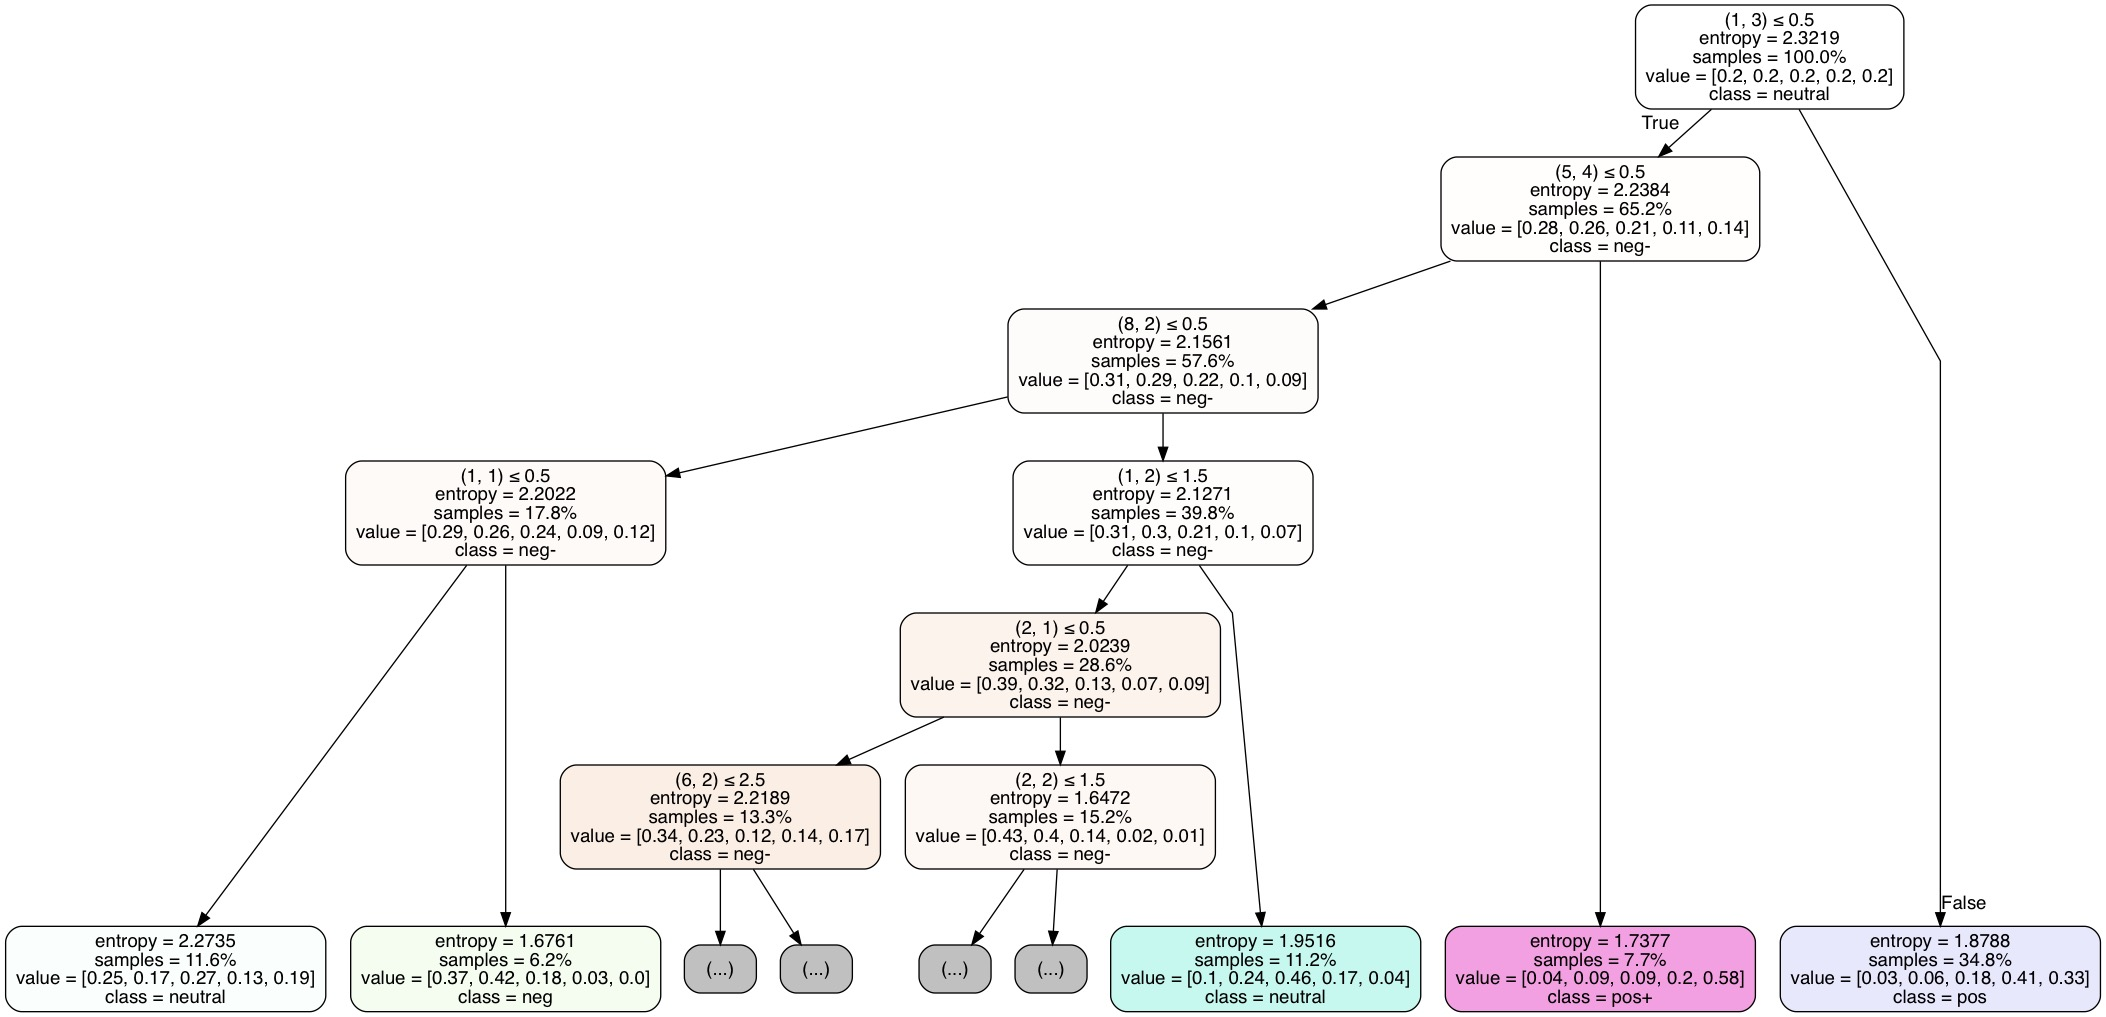

In [6]:
#ignore
# show feature importance
import joblib
from operator import itemgetter
from IPython.display import SVG, Image
import numpy as np
import pandas as pd
import scipy as sp
import sklearn.pipeline
import pyximport
pyximport.install(inplace=True)
from _aux import process_joint_features

#load decision tree model
tree_results = load_model(os.path.join('data', 'tree_single.model'))
#estimator, vectorizer, preproc, (learning_result, test_acc), (train), (valid), (test)
feature_names, ent_importance, ent_dt = get_feature_info(*tree_results[:2])
assert(hasattr(ent_dt, 'tree_'))
graph = display_decision_tree(ent_dt, feature_names)
# any IPython.display.* objects should be placed at topmost level
# cannot placed within block
Image(graph.create_jpeg(), retina=True, embed=True)

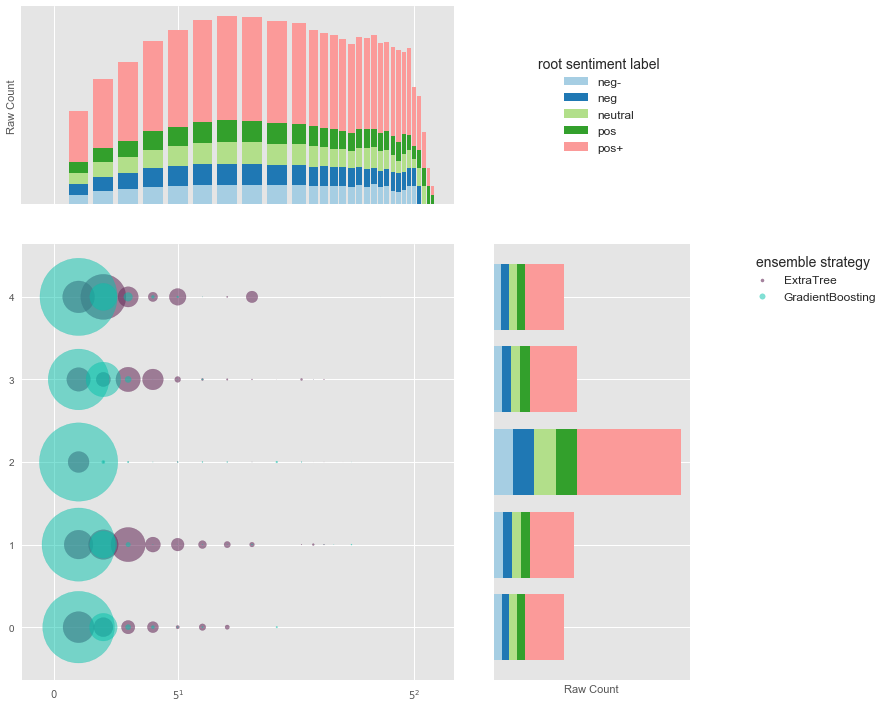

In [25]:
#ignore
from functools import reduce
import numpy
import operator
import pandas as pd

# loading ensemble model
ensemble_results = load_model(os.path.join('data', 'ensemble_single.model'))
#estimator, vectorizer, preproc, (learning_result, test_acc), (train), (valid), (test)
ensemble_features = get_feature_info(*ensemble_results[:2])

# loading boost model
boost_results = load_model(os.path.join('data', 'boost_single.model'))
boost_features = get_feature_info(*boost_results[:2])

# ensure both use the same training_features and targets
numpy.testing.assert_array_almost_equal(ensemble_results[4][-1], boost_results[4][-1])
numpy.testing.assert_array_almost_equal(ensemble_results[5][-1], boost_results[5][-1])
numpy.testing.assert_array_almost_equal(ensemble_results[-1][-1], boost_results[-1][-1])

# get the samples with nomial feature or before vectorized
train_features = ensemble_results[4][0] # train_features for both ensemble and boost should the same
train_targets =  ensemble_results[4][-1] # train_targets for both ensemble and boost should the same
samples = process_joint_features((train_features['sentiments'].tolist(), train_features))
# will form nth sampe, true_target, level, label and passing to pd.DataFrame
assert(len(samples) == len(train_targets))
stacking = [(i, y, le, la, cnt) for i, (x, y) in enumerate(zip(samples, train_targets)) 
                    for (le, la), cnt in x.items()]
train_df = pd.DataFrame.from_records(stacking, 
                                     columns=['index', 'sentiment', 'levels', 'labels', 'counts'])

n_levels, n_classes = train_df['levels'].max() + 1, train_df['labels'].max() + 1

ensemble_area = numpy.pi * (300 * ensemble_features[1]).power(2)
boost_area = numpy.pi * (300 * boost_features[1]).power(2)

# plot
sns.set_palette("Paired", n_colors=5)
xx, yy = numpy.meshgrid(numpy.arange(n_levels), numpy.arange(n_classes), indexing='ij')
z1 = ensemble_area[xx.ravel(), yy.ravel()].A1
z2 = boost_area[xx.ravel(), yy.ravel()].A1
x = xx.ravel()
y = yy.ravel()

g = sns.JointGrid(x='Levels', y='Labels', data=train_df, ratio=2, size=10)
g.ax_joint.set_xscale('symlog', basex=5, linthreshx=10)
g.ax_joint.scatter(x, y, s=z1, alpha=0.6, label='ExtraTree', color=sns.xkcd_rgb['grape'])
g.ax_joint.scatter(x, y, s=z2, alpha=0.5, label='GradientBoosting', color=sns.xkcd_rgb['turquoise'])
g.ax_joint.legend(loc='upper right', bbox_to_anchor=(2.0, 1.0), title="ensemble strategy",
                      markerscale=0.1)

groupby_root_sentiment = train_df.groupby('sentiment')
by_sentiments = numpy.empty((n_classes,), dtype=numpy.object)
for group_id, subgrp in groupby_root_sentiment:
  by_sentiments[group_id] = (subgrp[['counts', 'levels']].groupby('levels').apply(numpy.mean),
                             subgrp[['counts', 'labels']].groupby('labels').apply(numpy.mean))
height_ = numpy.zeros(30) # marg_x, height for vertical bar
left_ = numpy.arange(0, 30) # marg_x, left for vertical bar
width_ = numpy.zeros(5) # marg_y, height for horozontal bar
g.ax_marg_x.set_xscale('symlog', basex=5, linthreshx=10)
g.ax_marg_x.set_ylabel('Raw Count')
g.ax_marg_y.set_xlabel('Raw Count')
for i, (marg_x, marg_y) in enumerate(by_sentiments):
  base_ = height_.copy()
  height_[marg_x['levels'].astype(numpy.int)] += marg_x['counts'].values
  g.ax_marg_x.bar(left=left_, height=height_, bottom=base_, label=sentiment_labels[i])
  # need to add g.ax_marg_x.yaxis ticks and tick labels
  init_ = width_.copy()
  width_[marg_y['labels'].astype(numpy.int)] += marg_y['counts'].values
  g.ax_marg_y.barh(bottom=numpy.arange(5), width=width_, left=init_)
  # need to add g.ax_marg_y.yaxis ticks and tick labels
_ = g.ax_marg_x.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8), title="root sentiment label")

Furthermore, we will compare resampling-based **ExtraTreeClassifier** and boost-based **GradientBoostingClassifier** in the learning curve setting. The result is shown in the figure below. In addition to the common learning curve practice where data will be cross-validated (the first row of figure below), we also want to know how the performance of classifier changes as the data are trained in a specific order (the second row of figure below). 

Firstly, we can see that resampling-based classifier (green) outperforms single decision tree (blue) without being crippled by the high and sparse dimensional features. It also exhibited robustness to overfitting in larger size of training examples as expected. Resampling-based classifier also showed smaller fluctuations than greedy-based tree classifier because the stochasticity resulting from local optimal splits is smoothed out through larger number of estimators used (50 estimators used). One thing worth noticing is that the learning curves plotted against training set present here are not well-behaved or non-decreasing as one would expect a good learning algorithm might do. Many factors could result in not well-behaved learning curve especially for algorithms which rely on greedy solution or randomn resampling. Even if learning curve is not well-behaved, one can still tell the overall trend where accuracy increases with larger training size except boost-based classifier. Boost-based classifier shows overfitting across all numbers of training size. However, overfittig is gradually alleviated as the number of training examples increases. Both boost- and resampling-based classifiers have similar performance on cross-validation experiment but boost-based slightly better. 

Secondly, we would like to examine how the classifiers perform when the training examples are present in a specific order. The order of training examples present to classifiers is created based on their sizes and trees of greater size are added into training set as the number of training examles increments. No additional random data partition will be conducted and classifiers built on different training sizes will be tested against the same validate set. By doing so, the randomness of data partition can be eliminated from curve construction. Any deviation from well-behaved learning curve will be mainly attributed to the algorithm itself. To furhter smooth out the randomness in algorithms, ten similar runs are performed with different seeds to get the average and standard deviation. Notice **GradientBoostingClassifier** and **ExtraTreeClassifier** scikit-learn implementations have no incremental fitting (no partial_fit method) and previous training result is not incorporated into the training with greater sizes (```warm_start=False```). Further, no subsampling is specified in **GradientBoostingClassifier** and full batch gradient descent is used. 

The overall trend of three classifers in the second expriment is similar to the random data partition experiment but with greater standard deviation. Though not well-behaved, the training and validate curves of decision tree are climbing up with a few ups and downs. When comparing the random data partition setting with presorting setting, one can find that boost-based classfier is impacted more than resampling-based from both plots. Firstly, the overfitting is slightly improved as training with presorting order. In the presorting order, boost-based classifier could achieve better validation accuracy with smaller number of training size (roughly estimated ~11% average difference between training and validation accuracy for 2200+ training size in presorting and 6190 in not presorting). This is almost as good as resampling-based one. This might furhter imply the possiblity of finding a good descending direction in early training stage if classifier are trained based on certain [curriculum](https://goo.gl/okmR1s). Another interesting observation is boost-based classifier shows a valley both in training (shallow and flat) and validation (deep and sharp) curve around 1000 - 2000 training examples while resampling-based doesn't. This might indicate possible discontinuity existing in loss surface likely due to specific features missing out in this batch of trarining examples.  

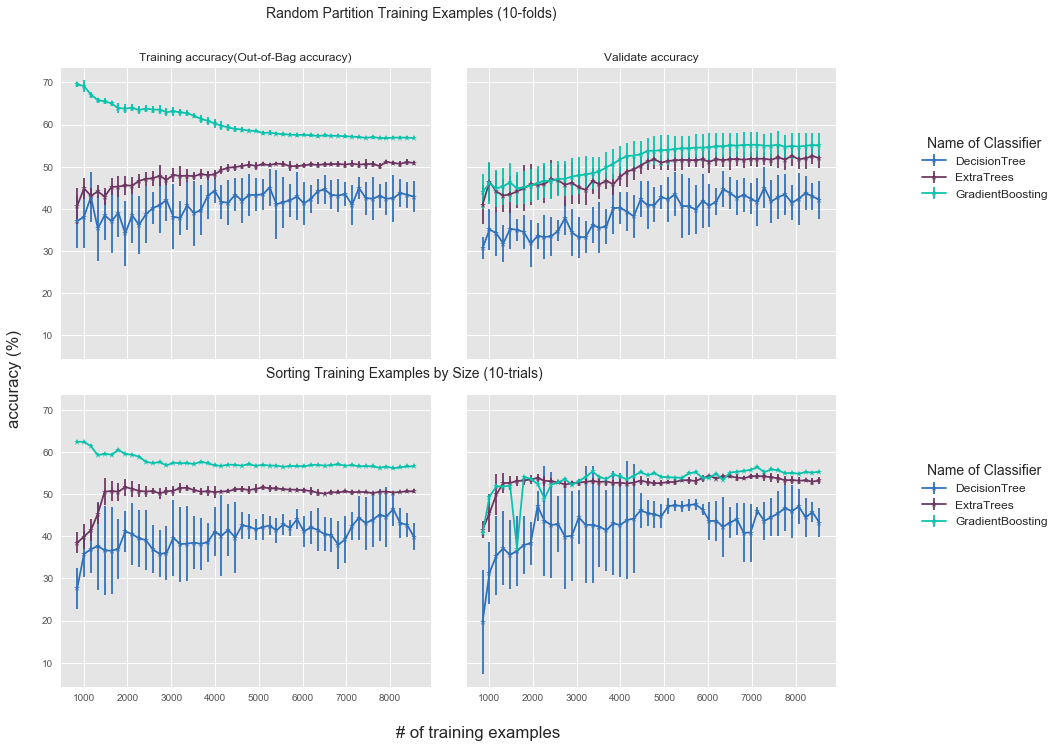

In [26]:
#ignore 
from operator import itemgetter
import os
import joblib
import numpy
exec_dec, exec_ens, exec_bst = joblib.load(os.path.join('data','single_classifier_exps.pkl'))

# exec_dec: num_of_experiments x (learning_result, test_accuracy) x 
# (learning_result: number of training examples x training_accuracy for each training examples x 
# validation_accruacy for each tranining examples)
exec_dec = tuple(zip(*map(itemgetter(0), exec_dec)))
exec_ens = tuple(zip(*map(itemgetter(0), exec_ens)))
exec_bst = tuple(zip(*map(itemgetter(0), exec_bst)))

train_examples = exec_dec[0][0]
dt_acc = cal_acc(exec_dec)
en_acc = cal_acc(exec_ens)
bs_acc = cal_acc(exec_bst)

#plot
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))
fig.text(0.45, 0, '# of training examples', fontsize='large')
fig.text(0., 0.55, 'accuracy (%)', fontsize='large', rotation='vertical')

fig.text(0.3, 1., 'Random Partition Training Examples (10-folds)', 
         fontstretch='semi-expanded', horizontalalignment='left')
for i, title in enumerate(['Training accuracy(Out-of-Bag accuracy)', 'Validate accuracy']):
  axes[0, i].set_title(title)
  axes[0, i].errorbar(train_examples, 100*tree_results[3][0][i + 1].mean(axis=1), 
                   yerr=100*tree_results[3][0][i + 1].std(axis=1),
                   fmt='-*', label='DecisionTree', color=sns.xkcd_rgb['medium blue'])
  axes[0, i].errorbar(train_examples, 100*ensemble_results[3][0][i + 1].mean(axis=1), 
                   yerr=100*ensemble_results[3][0][i + 1].std(axis=1),
                   fmt='-*', label='ExtraTrees', color=sns.xkcd_rgb['grape'])
  axes[0, i].errorbar(train_examples, 100*boost_results[3][0][i + 1].mean(axis=1), 
                   yerr=100*boost_results[3][0][i + 1].std(axis=1),
                   fmt='-*', label='GradientBoosting', color=sns.xkcd_rgb['turquoise'])
_= axes[0, 1].legend(loc="upper right", bbox_to_anchor=(1.6, 0.8),
                  title='Name of Classifier')

fig.text(0.3, 0.5, 'Sorting Training Examples by Size (10-trials)', 
         fontstretch='semi-expanded', horizontalalignment='left')
for i, title in enumerate(['Training accuracy(Out-of-Bag accuracy)', 'Validate accuracy']):
  axes[1, i].errorbar(train_examples, 100*dt_acc[i, :, :].mean(axis=0), 
                   yerr=100*dt_acc[i, :, :].std(axis=0),
                   fmt='-*', label='DecisionTree', color=sns.xkcd_rgb['medium blue'])
  axes[1, i].errorbar(train_examples, 100*en_acc[i, :, :].mean(axis=0), 
                   yerr=100*en_acc[i, :, :].std(axis=0),
                   fmt='-*', label='ExtraTrees', color=sns.xkcd_rgb['grape'])
  axes[1, i].errorbar(train_examples, 100*bs_acc[i, :, :].mean(axis=0), 
                   yerr=100*bs_acc[i, :, :].std(axis=0),
                   fmt='-*', label='GradientBoosting', color=sns.xkcd_rgb['turquoise'])
  
_= axes[1, 1].legend(loc="upper right", bbox_to_anchor=(1.6, 0.8),
                  title='Name of Classifier')
fig.tight_layout(pad=2.5)

Finally, we should examine the original problem to see if the information present here can be used in actual prediction task. In the following experiment, a stacking-like two-tier classifier is constructed. The top most classifier still use ensemble-based classifiers (**ExtraTreeClassifier** and **GradientBoostingClassifier**) as in previous experimental settings. The bottom layer is multiple dummy classifiers which do not "learn" the rule from word features but arbitrarily assign random guess based on the prior given. The actual implementation of dummy classifier is adopted from scikit-learn **DummyClassifier** passing *"stratified"* as strategy. Contrary to the scikit-learn original implementation, the non-root label priors are not estimated from given training examples but solely depending on the given prespecified priors. By introducing a dummy classifier at the bottom level, we can examine how two classifiers handle imperfect predictions when comparing the perfect ones shown in above experiments. The multiple dummy classifiers are constructed for each level and used to predict the sentiment label of non-root nodes at that level. We also set a maximal level to construct predictors for non-root sentimental labels since finer grained division might not be able to have sufficient training examples. However, only the number of predictors are constrained to the maximal level, the full number of levels is still used as joint features with predicted non-root sentimental labels. For the reason, it might give additional power to predict root sentiment. Here, we use 8 as maximal level for number of label predictors (this is an arbitrary choice). 

In order to create some worse scenarios, six pre-specified priors are given to the dummy classifier. They are "uniform", "neg- dominating", "neg dominating", "neutral dominating", "pos dominating" and "pos+ dominating". The dominating class would have as high as 0.8 belief in pre-specified prior distribution. The prior distributions specified here are all arbitrary choices and being here for the reason to demonstrate how boost and resampling-based adjust their importance in order to optimize the root sentiment classification. 

As you can see in the following plot, the accuracy for non-root sentimental label prediction is plotted against level for each prior settings. In each setting, boost-based is plotted as the normal way but resampling-based is upside-down. The target accuracy, root sentiment (or accuracy at level 0), are all close. (Around 20% or close to random guess with 1/5 chance for each class and 28% for boost). Accuracy as such shows how both classifers at top-tier are robust to the performance of bottom-tier label predictors especially most of them are intentionally biased towards favoring the incorrect labels (by giving wrong belief). In order to further examine how two classifiers handle noisy predictions, feature importance across all levels is plotted in stacking bar chart for each setting.  The contribution of predicted sentiment at non-root levels can be seen in each bar with different color. For levels greater than the maximal number of predictors whose feature importance will be summed with the one at maximal level allowed to construct predictors. As a result, the high importance of the last level is actually a collective quantity from the levels greater than the maximal level allowed to construct label predictors.  

In [27]:
#ignore
from sklearn.pipeline import Pipeline
from run_naive_bayes import DummyProxy
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, 
                             confusion_matrix, average_precision_score)
from sklearn.preprocessing import label_binarize
from operator import itemgetter
from collections import deque
import joblib
import numpy
import pandas
import pyximport
pyximport.install(inplace=True)
from _aux import *

ensemble_mresults = load_model(os.path.join('data', 'ensemble_dumb_multi.model'))
boost_mresults = load_model(os.path.join('data', 'boost_dumb_multi.model'))
#searcher, vectorizer, preproc, label_searchers, (train), (valid), (test)
params = ['uniform_priors', 'neg- dominating', 'neg dominating', 
          'neutral dominating', 'pos dominating', 'pos+ dominating']
max_level = len(ensemble_mresults[3])
plot_fimp, (root_test_mean_scores, root_test_std_scores), \
        (test_mean_scores_per_level, test_std_scores_per_level), _ = get_multi_info(ensemble_mresults)
plot_bfimp, (boost_test_mean, boost_test_std), \
        (boost_test_mean_per_level, boost_test_std_per_level), _ = get_multi_info(boost_mresults)
root_test_mean_scores = -1 * root_test_mean_scores
test_mean_scores_per_level = -1 * test_mean_scores_per_level
plot_fimp = list(map(lambda x: -1*x, plot_fimp))

# test_targets should be the same
numpy.testing.assert_array_equal(ensemble_mresults[-1][-1], boost_mresults[-1][-1]) 
numpy.testing.assert_array_equal(ensemble_mresults[-1][-1], boost_results[-1][-1])

true_y = ensemble_mresults[-1][-1]

ensemble_y_pred = get_predictions(ensemble_results)
ensemble_cnf = confusion_matrix(true_y, ensemble_y_pred)

boost_y_pred = get_predictions(boost_results)
boost_cnf = confusion_matrix(true_y, boost_y_pred)

ensemble_y_mpred = get_predictions(ensemble_mresults)
boost_y_mpred = get_predictions(boost_mresults)
ensemble_mcnf = confusion_matrix(true_y, ensemble_y_mpred)
boost_mcnf = confusion_matrix(true_y, boost_y_mpred)

Xt, Yt = group_cv(ensemble_mresults[-1][0], ensemble_mresults[2], ensemble_mresults[3], max_level)

# compute non-root scores
metrics = {}
metrics['auc'] = numpy.empty((n_classes, len(params), max_level), dtype=numpy.float32)
for i, param_name in enumerate(params):
  label_predictors = ensemble_mresults[0].cv_results_['params'][i]['transformer'].kw_args['label_predictors']
  for j in range(max_level):
    assert(hasattr(label_predictors[j].named_steps['classifier'], 'theta_')
          or hasattr(label_predictors[j].named_steps['classifier'], 'class_prior_')) # must be fitting
    probas = label_predictors[j].predict_proba(Xt[j][0]) # one-hot encoding
    indicators = label_binarize(Yt[j][0], numpy.arange(n_classes))
    for k in range(n_classes):  
      metrics['auc'][k, i, j] = roc_auc_score(indicators[:, k], probas[:, k])

# compute root scores
rocs = [[[list() for _ in params] for _ in range(2)] for _ in range(n_classes)]
one_hot_y = label_binarize(true_y, numpy.arange(n_classes))
for i, param_name in enumerate(params):
  for j, mresults in enumerate([ensemble_mresults, boost_mresults]):
    x = mresults[-1][0]
    for name in ['transformer', 'classifier']:
      trans = mresults[0].cv_results_['params'][i][name]
      if name == 'transformer':
        x = trans.transform(x)
      elif name == 'classifier':
        probas = trans.predict_proba(x)
      else:
        raise ValueError('estimator %s cannot be applied' % name)
    for k in range(n_classes):  
      rocs[k][j][i] = roc_auc_score(one_hot_y[:, k], probas[:, k])
rocs = numpy.asarray(rocs)

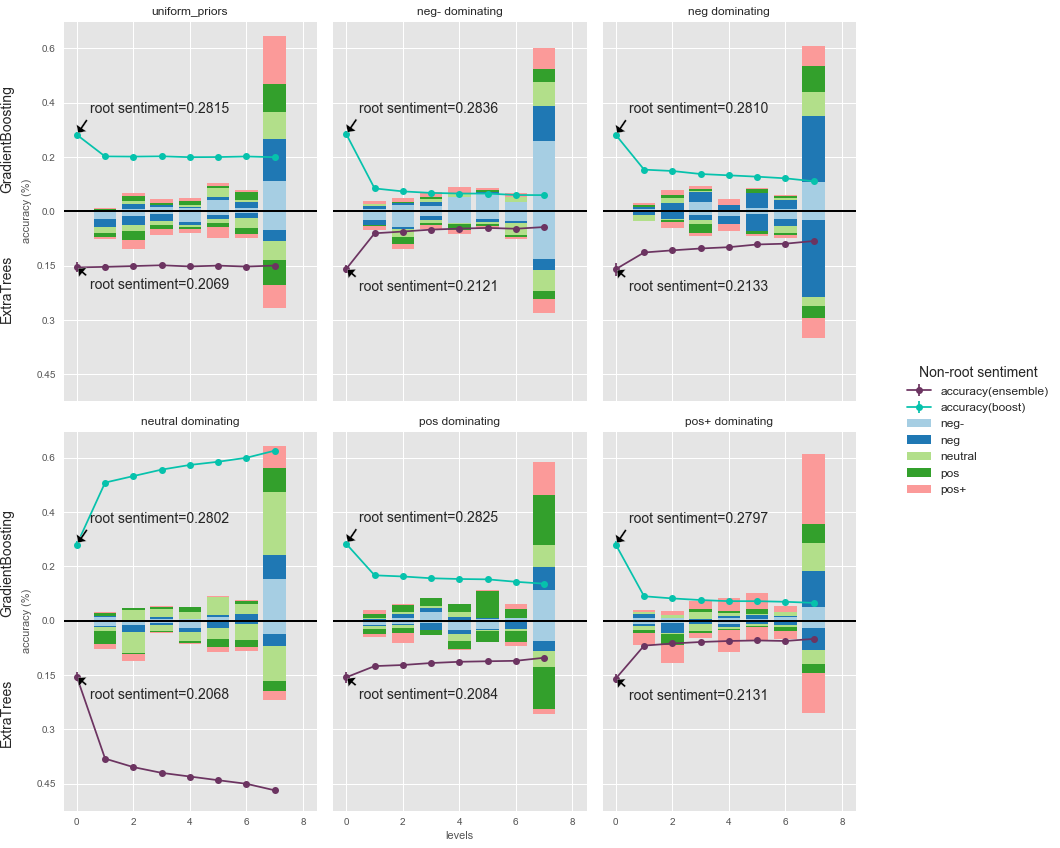

In [28]:
#ignore
fig, axes = plt.subplots(2 , 3, sharex=True, sharey=True, figsize=(12, 12))

axes[0, 0].set_xlim([-0.5, max_level + 0.5])
axes[0, 0].set_ylim([-0.7, 0.7])
axes[0, 0].set_yticklabels(numpy.hstack([numpy.linspace(0.6, 0.0, 4, endpoint=False),
                                       numpy.linspace(0., 0.6, 4, endpoint=True)]))
axes[0, 0].set_ylabel('accuracy (%)')
axes[1, 0].set_ylabel('accuracy (%)')
axes[1, 1].set_xlabel('levels')
axes[0, 0].annotate('GradientBoosting', xy=(0, 0.9), xycoords='figure fraction',
                   horizontalalignment='left', verticalalignment='top', rotation=90)
axes[0, 0].annotate('ExtraTrees', xy=(0, 0.7), xycoords='figure fraction',
                   horizontalalignment='left', verticalalignment='top', rotation=90)
axes[1, 0].annotate('GradientBoosting', xy=(0, 0.4), xycoords='figure fraction',
                   horizontalalignment='left', verticalalignment='top', rotation=90)
axes[1, 0].annotate('ExtraTrees', xy=(0, 0.2), xycoords='figure fraction',
                   horizontalalignment='left', verticalalignment='top', rotation=90)
for r in range(2): # rows
  for c in range(3): # columns
    pname = params[r * 3 + c]
    # plot root + non-root accurcy per-level
    cur_mean = deque(test_mean_scores_per_level[r * 3 + c].tolist()[1:]) # exclude root
    cur_std = deque(test_std_scores_per_level[r * 3 + c].tolist()[1:]) # exclude root
    # adding root accurcy as level 0 
    cur_mean.appendleft(root_test_mean_scores[r * 3 + c])
    cur_std.appendleft(root_test_std_scores[r *3 + c])
    axes[r, c].plot(numpy.arange(-1, max_level + 2), numpy.zeros((max_level + 3,)), lw=2.0, c='k')
    axes[r, c].errorbar(numpy.arange(max_level), cur_mean, 
                   yerr=cur_std,
                   fmt='-o', label='accuracy(ensemble)', color=sns.xkcd_rgb['grape'])
    boost_mean = deque(boost_test_mean_per_level[r * 3 + c].tolist()[1:]) # exclude root
    boost_std = deque(boost_test_std_per_level[r * 3 + c].tolist()[1:]) # exclude root
    boost_mean.appendleft(boost_test_mean[r * 3 + c])
    boost_std.appendleft(boost_test_std[r *3 + c])
    axes[r, c].errorbar(numpy.arange(max_level), boost_mean, 
                   yerr=boost_std,
                   fmt='-o', label='accuracy(boost)', color=sns.xkcd_rgb['turquoise'])
    axes[r, c].annotate('root sentiment=%.4f' % (-1 * cur_mean[0]), xy=(0, cur_mean[0]), 
                        xytext=(0.45, cur_mean[0] - 0.08), 
                        arrowprops=dict(facecolor='black', width=2.0, 
                                        headlength=6.0, shrink=0.1))
    axes[r, c].annotate('root sentiment=%.4f'%(boost_mean[0]),
                        xy=(0, boost_mean[0]), xytext=(0.45, boost_mean[0] + 0.08),
                        arrowprops=dict(facecolor='black', width=2.0,
                                       headlength=6.0, shrink=0.1))
    axes[r, c].set_title(pname)
    # plot feature importance for ensemble
    for i in range(n_classes):
      cur_hgt=plot_fimp[r * 3 + c][:, i + 1]-plot_fimp[r * 3 + c][:, i]
      axes[r, c].bar(left=numpy.arange(max_level), height=cur_hgt, 
                     bottom=plot_fimp[r * 3 + c][:, i], label=sentiment_labels[i])
    # plot feature importance for boost 
    for i in range(n_classes):
      cur_hgt=plot_bfimp[r * 3 + c][:, i + 1] - plot_bfimp[r * 3 + c][:, i]
      axes[r, c].bar(left=numpy.arange(max_level), height=cur_hgt, 
                     bottom=plot_bfimp[r * 3 + c][:, i])
_ = plt.legend(loc="center right", bbox_to_anchor=(1.8, 1.0),
                  title='Non-root sentiment')
plt.tight_layout()

Two classifiers show similar trend for all six priors settings except boost-based has higher accuracy than resampling based one. This is innate ability for boost-based classifier which is designed for boost performance from a few weak learners. And it did to give ~28% accuracy which resampling-based is pale to comparison. But the performance of classifier in individual experiment settings can overall divided into two categories. One is the label predictors consistently outperform the root sentiment predictor such as in neutral dominating settings. The other is all the label predictors performs worse or no better than the targeting root sentiment predictor and the other five prior settings are falling into this category. As you can see the trends in these two categories are inverse, predicting neurtral sentiment correctly is not quite useful as much as giving overall low prediction accuracy across all levels as neg- dominating setting (but not for pos+). 

For the feature importance part, two classifiers shows importance shifting from the smaller level to the middle level when predicted labels are used. This is especially true for feature importance reported by boost-based classifier where the first two levels are no longer dominating and employs resampling-like straregy to distribute importance evenly. In addition to the importance shifting, one can see the feature importance reflects what biased belief provided by the prespecified priors. For example, in the pos+ dominating prior setting, all level would prefer to give pos+ more importance. So do the rest four except uniform. Uniform prior setting is evenly distributing importance in all sentiment labels but have different preferences in some specific levels. To get a closer view about our biased priors affect non-root sentiment predictions. Below is a plot of AUC (area under receiver operating characteristic curve) against levels. Each column is the AUC of that titled non-root sentiment prediction result of **GradientBoostingClassifier**. Using AUC is because it is not heavily biased by the false positive and would not give misled conclusion. As you can see in the following figure, only neg- sentiment label is heavily benefited from same dominating prior and explain the better performance for boost-based classifier. This might indicate the combat strategy employed by two classifiers is just looking for useful pattern in the biased predictions and perhaps consistent bad predictions still make a useful pattern for root sentiment predictions.  

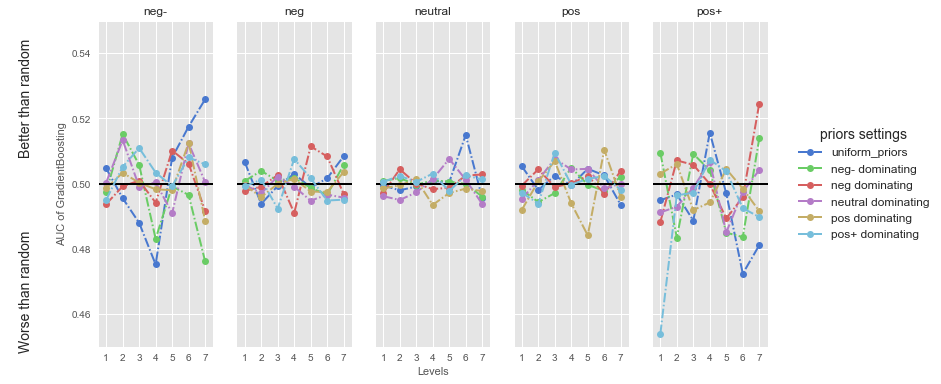

In [39]:
#ignore
with sns.color_palette('muted', n_colors=6):
  fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12, 6))
  aucs = metrics['auc']
  # plot auc vs levels 
  axes[0].set_ylim(0.45, 0.55)
  axes[0].set_xlim(0.5, 7.5)
  axes[0].set_xticks(numpy.arange(1, 8))
  axes[0].set_ylabel('AUC of GradientBoosting')
  axes[0].annotate('Better than random', xy=(0.02, 0.9), xycoords='figure fraction',
                   horizontalalignment='left', verticalalignment='top', rotation=90)
  axes[0].annotate('Worse than random', xy=(0.02, 0.4), xycoords='figure fraction',
                   horizontalalignment='left', verticalalignment='top', rotation=90)
  for cur_class, label_name in enumerate(sentiment_labels):
    axes[cur_class].set_title(label_name)
    for i, pname in enumerate(params):
      axes[cur_class].plot(numpy.arange(max_level + 2), 
                           0.5 * numpy.ones((max_level + 2,)), '-', lw=2.0, c='k')
      # boosting
      axes[cur_class].plot(numpy.arange(1, max_level), metrics['auc'][cur_class][i][1:], 
                      'o-.', label=pname, lw=2)
  _ = plt.legend(loc="center right", bbox_to_anchor=(2.5, 0.5), 
                 title='priors settings')
  axes[2].set_xlabel('Levels')

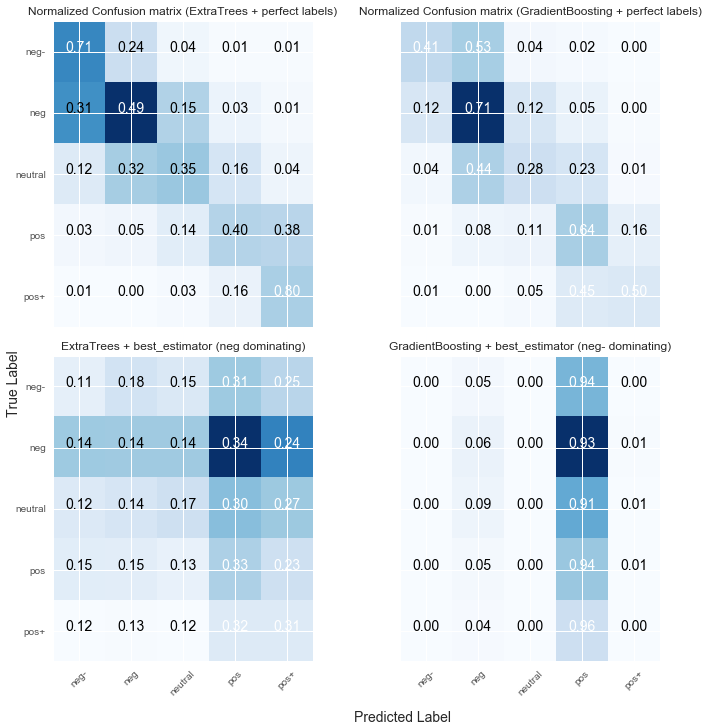

In [42]:
#ignore
#ploting confusion matrix for boost and ensemble single
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
plot_confusion_matrix(ensemble_cnf, classes=sentiment_labels,
                      title='Normalized Confusion matrix (ExtraTrees + perfect labels)',
                      normalize=True, ax=axes[0, 0])
plot_confusion_matrix(boost_cnf, classes=sentiment_labels,
                      title='Normalized Confusion matrix (GradientBoosting + perfect labels)',
                      normalize=True, ax=axes[0, 1])

#ploting confusion matrix for boost and ensemble multi
plot_confusion_matrix(ensemble_mcnf, classes=sentiment_labels,
                      title='ExtraTrees + best_estimator (%s)' % (params[ensemble_mresults[0].best_index_]),
                      normalize=True, ax=axes[1, 0])
plot_confusion_matrix(boost_mcnf, classes=sentiment_labels,
                      title='GradientBoosting + best_estimator (%s)' % (params[boost_mresults[0].best_index_]),
                      normalize=True, ax=axes[1, 1])
plt.annotate('True Label', xy=(0.01, 0.5), xycoords='figure fraction', rotation=90) # y-label
plt.annotate('Predicted Label', xy=(0.5, 0.0), xycoords='figure fraction') # x-label
plt.tight_layout()

Another view to see how boost-based and resamping-based classifier handle imperfect labels, we further present the [confusion matrices](https://en.wikipedia.org/wiki/Confusion_matrix) for the root sentiment classification with perfect and predicted non-root sentiments. 

As you can observe from confusion matrices for two classifiers with perfect labels (first row) and best performance  from six prespecified prior settings (second row, they ar neg dominating for **ExtraTreeClassifier** and neg- dominating for **GradientBoostingClassifier**). Two classifiers lose their true-positive counts for each root sentiment class and redistribute them by two different strategies. Resampling-based classifier tend to distribute its predictions to all classes on average with the price of low sensitivity (high false negative) but high precision. On the other hand, boost-based classifier is heavily biased by the wrong belief and fooled by the prespecified priors in order to achieve a low precision (high false positive) but high sensitivity result. 

The study present here is a partial and incomplete work for the purpose to understand better for how to handle data. The questions asked within the general machine learning context is how higher level mapping (tree node to sentiment label) can be used as features and how these labels can degrade the final prediction goal when they are corrupt. When more applications incorporate label embedding as part of learning scheme such as object recognition in computer vision, this study might show that additional measure needs to be taken as the fact [poor generalization for deep neural network](https://blog.acolyer.org/2017/05/11/understanding-deep-learning-requires-re-thinking-generalization/) exists. The questions asked within the specific domain such as sentiment predictions are how incorrect and noisy sentiment labels should be expected from crowdsourcing work when there is no cheap way to measure human sentiment precisely. However, handling the imperfect "ground truth" is part of a statistician's daily life. To make machine learning actually work in the real life, such expectation should be considered when designing training framework. 

In this study, we have a rough upper bound of the root sentiment prediciton accuracy given joint features formed by highly confident parsing tree and perfect non-root sentiment label. We also have lower bound when the arbitrary non-root sentiment are assigned. But how much improvement would be made when word embeddings are incorporated in root sentiment predictions?  

Much later!